<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
    Machine learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2024<br>
<font color=3C99D size=5>
    Practical Assignment 5 - NLP - Skip-Gram <br>
<font color=0CBCDF size=4>
   Ayeen Poostforoushan
</div>

____

<font color=0080FF size=3>
This notebook explores word embeddings, compact and dense vector representations of words that capture their textual meaning. This notebook focusing on implementing the Word2Vec algorithm using the Skip-gram architecture and negative sampling.
</font>
<br>

**Note:**
<br>
<font color=66B2FF size=2>In this notebook, you are free to use any function or model from TensorFlow to assist with the implementation. However, PyTorch is not permitted for this exercise. This ensures consistency and alignment with the tools being focused on.</font>
<br>
<font color=red size=3>**Run All Cells Before Submission**</font>: <font color=FF99CC size=2>Before saving and submitting your notebook, please ensure you run all cells from start to finish. This practice guarantees that your notebook is self-consistent and can be evaluated correctly by others.</font>

<font color=#ffb578 size=3>
you are free to modify, add, or remove any cells as you see fit to complete your tasks. Feel free to change any of the provided code or content to better suit your understanding and approach to the problems.

- **Questions**: If you have any questions or require clarifications as you work through the notebook, please do not hesitate to ask. You can post your queries on Quera or reach out via Telegram.
- **Feedback**: We encourage you to seek feedback and engage in discussions to enhance your learning experience and improve your solutions.
</font>

In [ ]:
import io
import math
import gzip
import nltk
import time
import random
import numpy as np
import tensorflow as tf
import gensim.downloader as api
import tensorflow_datasets as tfds
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from collections import Counter
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Downloading Dataset
We're going to use text8 dataset. Text8 is first 100,000,000 bytes of plain text from Wikipedia. It's mainly used for testing purposes.

In [ ]:
def load_data():
  text8_zip_file_path = api.load('text8', return_path=True)
  with gzip.open(text8_zip_file_path, 'rb') as file:
    file_content = file.read()
  wiki = file_content.decode()
  return wiki

wiki = load_data()

[==================================================] 100.0% 31.6/31.6MB downloaded


### Preprocessing data

**Stopwords removal** - Begin by removing stopwords from the dataset, as they provide little to no value in learning word embeddings. Ensure your preprocessing pipeline filters out commonly used words such as "the," "and," or "of" that do not contribute to meaningful semantic relationships.

---

**Subsampling words** - In a large corpora, most frequent words can easily occur hundreds of millions of times and such words usually don't bring much information to the table.  It is of essential importance to cut down on their frequencies to mitigate the negative impact it adds. For example, co-occurrences of "English" and "Spanish" benefit much more than co-occurrences of "English" and "the" or "Spanish" and "of". To counter the imbalance between rare and frequent words Mikolov et. al came up with the following heuristic formula for determining probability to drop a particular word:

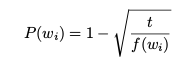

where t is threshold value (heuristically set to 1e-5) and f(w) is frequency of the word.

Implement a subsampling mechanism to handle overly frequent words in the corpus. Use the heuristic formula provided by Mikolov et al. to calculate the probability of dropping a word based on its frequency. This step ensures the corpus maintains a balance between rare and frequent words, improving the quality of word co-occurrence relationships.

---

**Filtering words** - Filter out words that occur only once in the dataset, as they lack sufficient context to be represented effectively. Retain only those words that appear at least five times in the corpus to minimize noise and enhance the overall quality of the embeddings.


In [ ]:
def preprocess_text(text):
    """
    Preprocesses the input text for further analysis.
    """
    # Step 1: Remove punctuation for normalization
    punctuation_set = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~'
    normalized_text = text.translate(str.maketrans('', '', punctuation_set))

    # Step 2: Convert to lowercase and trim extra spaces
    normalized_text = normalized_text.lower().strip()

    # Step 3: Remove stopwords
    common_words = set(stopwords.words('english'))
    token_list = normalized_text.split()
    filtered_tokens = [token for token in token_list if token not in common_words]

    # Step 4: Retain tokens with sufficient frequency
    token_frequency = Counter(filtered_tokens)
    significant_tokens = [token for token in filtered_tokens if token_frequency[token] >= 5]

    # Step 5: Subsample frequent tokens based on a threshold
    total_tokens_count = len(significant_tokens)
    token_probs = {token: count / total_tokens_count for token, count in token_frequency.items()}
    processed_tokens = [token for token in significant_tokens if random.random() < (1 / math.sqrt(token_probs[token] / 1e-5))]

    # Return the final tokens and their frequency counts
    return processed_tokens, token_frequency


It's always a good idea to take a quick look at preprocessed sample before heading further - you might observe few things that if handled can enrich or correct your data. More like a validation step this.

In [ ]:
# Take a quick look at a slice of preprocessed words (e.g., index 1500 to 1550)
processed_tokens, token_frequency = preprocess_text(wiki[:1000000])
print(processed_tokens[1500:1550])

### Hyperparameters
Setting a few hyperparamters required for gnerating batches and for deciding the size of word embeddings.



In [ ]:
EMBEDDING_DIM = 128
BUFFER_SIZE = 10000
BATCH_SIZE = 64
EPOCHS = 6

### Preparing TensorFlow Dataset using Skipgrams

**Generating Skipgrams**

Tokenize your preprocessed textual data and convert the words into their corresponding vectorized tokens. Then, use the `skipgrams` function provided by Keras to generate (word, context) pairs. Ensure the following steps are completed:

- Generate positive samples: (word, word in the same window), with label 1.  
- Generate negative samples: (word, random word from the vocabulary), with label 0.  

Refer to Mikolov et al.'s paper, [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781v3.pdf), for more details on Skipgrams.

---

**Negative Sampling**

For each input word, implement the negative sampling approach to optimize the training process. Transform the problem of predicting context words into independent binary classification tasks. For every (target, context) pair, generate random negative (target, ~context) samples. This step will reduce computational complexity and make training more efficient.


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(processed_tokens)

token_sequences = tokenizer.texts_to_sequences([processed_tokens])[0]

context_window = 5
skipgram_pairs, pair_labels = skipgrams(
    token_sequences, 
    vocabulary_size=len(tokenizer.word_index) + 1, 
    window_size=context_window, 
    negative_samples=1.0
)

word_targets, word_contexts = zip(*skipgram_pairs)
word_targets = np.array(word_targets, dtype="int32")
word_contexts = np.array(word_contexts, dtype="int32")
pair_labels = np.array(pair_labels, dtype="int32")

train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    list(zip(word_targets, word_contexts)), pair_labels, test_size=0.2, random_state=42
)

training_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels))
training_dataset = training_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

testing_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels))
testing_dataset = testing_dataset.batch(BUFFER_SIZE, drop_remainder=True)

In [ ]:
# Print the number of batches in the training and testing datasets
print(f"Training batches number: {len(list(training_dataset))}")
print(f"Testing batches number: {len(list(testing_dataset))}")

# (train, test) batches: 21445, 2382


### Building the Model

Use the model subclassing method to build your model. While Sequential and Functional APIs are generally more suitable for most use cases, model subclassing allows you to create the model in an object-oriented way. Follow these steps:

1. Define a custom model class by inheriting from `tf.keras.Model`.
2. Implement the `__init__` method to define the layers of your model.
3. Override the `call` method to define the forward pass of your model.
4. Ensure that the model includes embedding layers, a skip-gram architecture, and any other necessary components for training.


In [ ]:
class SkipGramModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size):
        super(SkipGramModel, self).__init__()
        self.word_embeddings = tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embedding_size, name="embedding_layer"
        )
        self.projection_layer = tf.keras.layers.Dense(1, activation='sigmoid', name="projection_layer")

    def call(self, data):
        target_words = data[:, 0]
        context_words = data[:, 1]
        target_embed = self.word_embeddings(target_words)
        context_embed = self.word_embeddings(context_words)
        similarity = tf.reduce_sum(target_embed * context_embed, axis=1)
        prediction = self.projection_layer(tf.expand_dims(similarity, axis=-1))
        return prediction

vocab_size = len(tokenizer.word_index) + 1
embedding_size = EMBEDDING_DIM

skipgram_model = SkipGramModel(vocab_size, embedding_size)

target_example = tf.constant([1, 2, 3, 4])
context_example = tf.constant([5, 6, 7, 8])

inputs_example = tf.stack([target_example, context_example], axis=1)

result = skipgram_model(inputs_example)

print("Predicted shape:", result.shape)
print("Predicted sample:", result[:4])


### Loss function, Metrics and Optimizers

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
train_acc_metric = tf.keras.metrics.BinaryAccuracy(name="train_accuracy")
val_acc_metric = tf.keras.metrics.BinaryAccuracy(name="val_accuracy")

### Training the Model

Implement custom training for learning word embeddings to gain finer control over optimization and training tasks. Follow these steps:

1. Define a custom training loop that includes forward propagation, loss computation, and backpropagation.
2. Use the optimizer of your choice to update the model's weights based on the computed gradients.
3. Implement batching for efficient data processing during training.
4. Monitor the loss during each epoch to track the model's performance.
5. Save the trained embeddings for later use once the training is complete.

In [ ]:
@tf.function
def train_step(model_obj, opt, loss_function, train_metric, data_batch, data_labels):
    with tf.GradientTape() as grad_tape:
        preds = model_obj(data_batch, training=True)
        batch_loss = loss_function(data_labels, preds)
    grads = grad_tape.gradient(batch_loss, model_obj.trainable_weights)
    opt.apply_gradients(zip(grads, model_obj.trainable_weights))
    train_metric.update_state(data_labels, preds)
    return batch_loss

@tf.function
def test_step(model_obj, loss_function, validation_metric, data_batch, data_labels):
    preds = model_obj(data_batch, training=False)
    batch_loss = loss_function(data_labels, preds)
    validation_metric.update_state(data_labels, preds)
    return batch_loss

epoch_count = EPOCHS
with tf.device('/GPU:0'):
    for epoch_idx in range(epoch_count):
        print(f"Epoch {epoch_idx + 1} begins.")
        start_timer = time.time()
        total_train_loss = 0.0
        total_validation_loss = 0.0
        
        for step_idx, (batch_inputs, batch_labels) in enumerate(training_dataset):
            train_loss = train_step(
                model_obj=skipgram_model, 
                opt=optimizer, 
                loss_function=loss_fn, 
                train_metric=train_acc_metric, 
                data_batch=batch_inputs, 
                data_labels=batch_labels
            )
            total_train_loss += train_loss.numpy()
        
        train_acc = train_acc_metric.result().numpy()
        print(f"Training accuracy for epoch: {train_acc:.4f}")
        print(f"Accumulated training loss: {total_train_loss:.4f}")
        train_acc_metric.reset_state()
        
        for step_idx, (batch_inputs, batch_labels) in enumerate(testing_dataset):
            validation_loss = test_step(
                model_obj=skipgram_model, 
                loss_function=loss_fn, 
                validation_metric=val_acc_metric, 
                data_batch=batch_inputs, 
                data_labels=batch_labels
            )
            total_validation_loss += validation_loss.numpy()
        
        validation_acc = val_acc_metric.result().numpy()
        print(f"Validation accuracy for epoch: {validation_acc:.4f}")
        print(f"Accumulated validation loss: {total_validation_loss:.4f}")
        val_acc_metric.reset_state()
        
        end_timer = time.time()
        epoch_duration = end_timer - start_timer
        print(f"Duration for this epoch: {epoch_duration:.2f}s\n")


Starting epoch: 0 
Training acc over epoch: 0.6210
Cummulative loss: 13484.8691 
Validation acc over epoch: 0.7072
Cummulative test loss: 1341.338867 
Time taken: 269.35s
Starting epoch: 1 
Training acc over epoch: 0.8254
Cummulative loss: 8453.4688 
Validation acc over epoch: 0.7842
Cummulative test loss: 1193.265137 
Time taken: 268.32s
Starting epoch: 2 
Training acc over epoch: 0.9158
Cummulative loss: 4827.6738 
Validation acc over epoch: 0.8211
Cummulative test loss: 1236.550415 
Time taken: 267.34s
Starting epoch: 3 
Training acc over epoch: 0.9533
Cummulative loss: 3010.3184 
Validation acc over epoch: 0.8390
Cummulative test loss: 1274.631592 
Time taken: 268.29s
Starting epoch: 4 
Training acc over epoch: 0.9704
Cummulative loss: 2110.4041 
Validation acc over epoch: 0.8517
Cummulative test loss: 1274.660400 
Time taken: 262.10s


In [ ]:
# Save weights to a Tensorflow Checkpoint file
checkpoint_path = "skipgram_model_checkpoint.weights.h5"

skipgram_model.save_weights(checkpoint_path)

### Word Embeddings Projector

Follow these steps to visualize the learned word embeddings using TensorFlow's Embedding Projector:

1. Extract the weights of the embedding layer from your trained model.
2. Save the weights into two files:
   - `vecs.tsv`: This file will store the actual vector representations of words.
   - `meta.tsv`: This file will store the associated metadata (e.g., word labels) for visualization.
3. Go to [TensorFlow Embedding Projector](http://projector.tensorflow.org/).
4. Upload the `vecs.tsv` and `meta.tsv` files created in the previous step.
5. Explore the visualizations provided by TensorFlow's Embedding Projector.
<font color=#ffb578>
6.Save the visualization of a word that best demonstrate the quality of your embeddings as an image and store it near the notebook.
7. Compress the folder into a `.zip` file and submit it as part of your work.

</font>


In [ ]:
# Step 1: Access the embedding layer from the trained model
# Retrieve the first layer (embedding layer) from the model

# Step 2: Extract the weights from the embedding layer
# Get the weights (word embeddings) as a NumPy array

# Step 3: Open files to store embeddings and metadata
# Create two files - 'vecs.tsv' for embeddings and 'meta.tsv' for word metadata

# Step 4: Iterate through the tokenizer's vocabulary
# For each word in the vocabulary, write its metadata and embeddings to the files

# Step 5: Close the files after writing
# Ensure that the files are properly saved and closed
embedding_layer = skipgram_model.get_layer("embedding_layer")
weights = embedding_layer.get_weights()[0]

vecs_path = "vecs.tsv"
meta_path = "meta.tsv"

vecs_file = open(vecs_path, "w")
meta_file = open(meta_path, "w")

for word, idx in tokenizer.word_index.items():
    vec = weights[idx]
    meta_file.write(word + "\n")
    vecs_file.write("\t".join([str(x) for x in vec]) + "\n")
    
vecs_file.close()
meta_file.close()

shape = np.loadtxt(vecs_path, delimiter="\t").shape
print(f"Word Embeddings shape: {shape}")

Word Embeddings shape: (12378, 128)
